# NLP Assignment #2 - Luke Schwenke

**Note:** records counts will be different, depending on when you query the API

In [232]:
import pandas as pd
import requests

In [233]:
%%time

# Define the API endpoint and parameters
url = "https://data.cityofchicago.org/resource/cwig-ma7x.json"

# Fetch the total count of records
def get_total_count(url):
    params = {
        "$select": "count(*)"
    }
    response = requests.get(url, params=params)
    data = response.json()
    return int(data[0]['count'])

total_count = get_total_count(url)
print(f"Total number of records available: {total_count:,.0f}")

Total number of records available: 266,229
CPU times: user 11.2 ms, sys: 5.28 ms, total: 16.4 ms
Wall time: 210 ms


In [234]:
%%time

# Fetch data and load it into a pandas DataFrame
def fetch_data(url, params):
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data)

# Set the limit parameter equal to the number of available records
params = {
    "$limit": total_count
}

# Fetch the data and load it into a DataFrame
df = fetch_data(url, params)

print(f'Number of records retrieved: {df.shape[0]:,.0f}')

Number of records retrieved: 266,229
CPU times: user 5.93 s, sys: 1.91 s, total: 7.83 s
Wall time: 28.9 s


In [235]:
df.head(3)

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,...,results,violations,latitude,longitude,location,:@computed_region_awaf_s7ux,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,2588013,SOLOWAY COFFEE,SOLOWAY COFFEE,2938639,Restaurant,Risk 1 (High),2275 N LINCOLN AVE,CHICAGO,IL,60614,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.92361620972698,-87.64599112233753,"{'type': 'Point', 'coordinates': [-87.64599112...",51,21190,68,798,34
1,2588012,L & L ACADEMY AND PRESCHOOL,L & L ACADEMY AND PRESCHOOL,2443069,Children's Services Facility,Risk 1 (High),1154-1158 W BELMONT AVE,CHICAGO,IL,60657,...,Pass,NaN,41.93995156136211,-87.65874263208119,"{'type': 'Point', 'coordinates': [-87.65874263...",38,4449,57,710,25
2,2588015,DON MEMO MEXICAN RESTAURANT,DON MEMO MEXICAN RESTAURANT,2863378,Restaurant,Risk 1 (High),10536 S TORRENCE AVE,CHICAGO,IL,60617,...,Pass w/ Conditions,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.70348287190127,-87.55975998992695,"{'type': 'Point', 'coordinates': [-87.55975998...",47,21202,48,174,47


## 1. Filter the data for failed inspections and only keep records where Violations description is not blank. 

In [236]:
# Filter the results column to where the results are "Fails"
df_f = df[df.results=='Fail']
print("There are now", df_f.shape[0], "rows in the dataset after we subset to only Fail results. There were", df.shape[0], "rows.")

There are now 51960 rows in the dataset after we subset to only Fail results. There were 266229 rows.


In [237]:
df_c = df_f.dropna(subset=['violations'])
df_c = df_c.reset_index(drop=True)
print("There are now", df_c.shape[0], "rows in the dataset after removing NaN's from violations")

There are now 48530 rows in the dataset after removing NaN's from violations


## 2. Using regex, separate the violation description and comments into separate data frame columns.

In [238]:
# VIOLATION DESCRIPTION

# First remove the numbers at the beginning
df_c['violation_description'] = df_c['violations'].str.replace(r'\d+|\.', '', regex=True)
# Second remove the commends and initial whitespace
df_c['violation_description'] = df_c['violation_description'].str.replace(r'- Comments:.*?(\||$)', '', regex=True)
df_c['violation_description'] = df_c['violation_description'].str.lstrip()

In [239]:
# COMMENTS

df_c['comments'] = df_c['violations'].str.extract(r'Comments: (.*?)(?:\||$)') #(r'- Comments: (.*?) \|')

In [240]:
import re
def strip_multiple_spaces(string):
    return re.sub(r'\s+', ' ', string).strip()
# Strip columns to single spaces
df_c['violation_description'] = df_c['violation_description'].apply(lambda x: strip_multiple_spaces(x))
df_c['comments'] = df_c['comments'].astype(str).str.strip().str.replace('\s+', ' ')

/var/folders/rx/2jqwhb8d31960xlz0g9vlmdh0000gn/T/ipykernel_47419/4187734932.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_c['comments'] = df_c['comments'].astype(str).str.strip().str.replace('\s+', ' ')


## 3. Tokenize violation description and comment columns

In [241]:
import nltk
from nltk import word_tokenize

vds = df_c.violation_description.apply(lambda x: word_tokenize(x))
com = df_c.comments.apply(lambda x: word_tokenize(x))


## 4. Find top-10 tokens of each column

In [242]:
from collections import Counter

vds_tokens = [token for tokens in vds for token in tokens]
com_tokens = [token for tokens in com for token in tokens]

In [243]:
word_dist = nltk.FreqDist(vds_tokens)
df_word_dist = pd.DataFrame(word_dist.most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')

print("Top 10 Words BEFORE Cleaning - Violation Descriptions")
df_word_dist.head(10)

Top 10 Words BEFORE Cleaning - Violation Descriptions


,Frequency
Word,
",",372604
AND,172943
:,128985
FOOD,89359
MAINTAINED,89321
&,80609
PROPERLY,74608
CLEAN,71479
INSTALLED,69322


In [244]:
word_dist = nltk.FreqDist(com_tokens)
df_word_dist = pd.DataFrame(word_dist.most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')

print("Top 10 Words BEFORE Cleaning - Comments")
df_word_dist.head(10)

Top 10 Words BEFORE Cleaning - Comments


,Frequency
Word,
.,151092
",",74098
AND,64911
THE,52085
TO,48620
IN,39582
OF,38239
ON,35980
AT,35322


## 5. Clean each column: convert to lower case, remove stopwords, punctuation, numbers, etc

In [245]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [246]:
def nlp_cleaner(column_to_clean):

    # Remove single-character tokens (mostly punctuation)
    words = [word for word in column_to_clean if len(word) > 1]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Remove stopwords
    words = [word for word in words if word not in stopwords]

    return words

In [247]:
vds_tokens_clean = nlp_cleaner(vds_tokens)
com_tokens_clean = nlp_cleaner(com_tokens)

## 6. Find Top-10 Tokens Again (After Cleaning)

In [248]:
word_dist = nltk.FreqDist(vds_tokens_clean)

df_word_dist = pd.DataFrame(word_dist.most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')

print("Top 10 Words AFTER Cleaning - Violation Descriptions")
df_word_dist.head(10)

Top 10 Words AFTER Cleaning - Violation Descriptions


,Frequency
Word,
food,89359
maintained,89321
properly,74608
clean,71479
installed,69322
constructed,68318
equipment,64932
surfaces,51522
cleaning,48295


In [249]:
word_dist = nltk.FreqDist(com_tokens_clean)

df_word_dist = pd.DataFrame(word_dist.most_common(10),
                    columns=['Word', 'Frequency']).set_index('Word')

print("Top 10 Words AFTER Cleaning - Comments")
df_word_dist.head(10)

Top 10 Words AFTER Cleaning - Comments


,Frequency
Word,
instructed,25851
observed,25283
violation,25124
food,24674
must,21070
issued,18562
citation,18279
area,17270
sink,15026


## 7. Find top-10 tokens after applying Porter stemming to the columns obtained in step 5

In [250]:
porter = nltk.PorterStemmer()

In [251]:
# Porter stem the cleaned Comments tokens
com_tokens_clean_porter_stemmed = [porter.stem(word) for word in com_tokens_clean]

In [252]:
# Porter stem the cleaned Violation Description tokens
vds_tokens_clean_porter_stemmed = [porter.stem(word) for word in vds_tokens_clean]

In [253]:
def get_top_n(tokens):
    word_dist = nltk.FreqDist(tokens)

    df_word_dist = pd.DataFrame(word_dist.most_common(10),
                        columns=['Word', 'Frequency']).set_index('Word')

    print(df_word_dist.head(10))

In [254]:
print("Violence Descriptions - Top 10 Words AFTER Cleaning AND Porter Stemming")
get_top_n(vds_tokens_clean_porter_stemmed)

Violence Descriptions - Top 10 Words AFTER Cleaning AND Porter Stemming
           Frequency
Word                
clean         147035
food           94615
maintain       92870
properli       74608
instal         69322
construct      68318
equip          64932
surfac         51522
contact        47987
use            42860


In [255]:
print("Comments - Top 10 Words AFTER Cleaning AND Porter Stemming")
get_top_n(com_tokens_clean_porter_stemmed)

Comments - Top 10 Words AFTER Cleaning AND Porter Stemming
          Frequency
Word               
food          31867
violat        27166
area          26221
instruct      25901
observ        25434
must          21071
issu          18742
sink          18584
citat         18351
provid        16590


## 8. Find top-10 tokens after applying Lancaster stemming to the columns obtained in step 5

In [256]:
lancaster = nltk.LancasterStemmer()

In [257]:
# Lancaster stem the cleaned Comments tokens
com_tokens_clean_lancaster_stemmed = [lancaster.stem(word) for word in com_tokens_clean]

In [258]:
# Lancaster stem the cleaned Violation Description tokens
vds_tokens_clean_lancaster_stemmed = [lancaster.stem(word) for word in vds_tokens_clean]

In [259]:
print("Violence Descriptions - Top 10 Words AFTER Cleaning AND Lancaster Stemming")
get_top_n(vds_tokens_clean_lancaster_stemmed)

Violence Descriptions - Top 10 Words AFTER Cleaning AND Lancaster Stemming
           Frequency
Word                
cle           156544
food           94615
maintain       92870
prop           92799
instal         69322
construct      68318
equip          64932
surfac         51522
contact        47987
us             42860


In [260]:
print("Comments - Top 10 Words AFTER Cleaning AND Lancaster Stemming")
get_top_n(com_tokens_clean_lancaster_stemmed)

Comments - Top 10 Words AFTER Cleaning AND Lancaster Stemming
          Frequency
Word               
food          31867
viol          27188
instruct      25903
observ        25435
found         21573
must          21071
issu          18742
sink          18584
cit           18362
are           17270


## 9. Find top-10 tokens after applying lemmatization to the columns obtained in step 5

In [261]:
wnl = nltk.WordNetLemmatizer()

In [262]:
# Lemmatize the cleaned Comments tokens
com_tokens_clean_lemmatized = [wnl.lemmatize(word) for word in com_tokens_clean]

In [263]:
# Lemmatize the cleaned Violence Description tokens
vds_tokens_clean_lemmatized = [wnl.lemmatize(word) for word in vds_tokens_clean]

In [264]:
print("Violence Descriptions - Top 10 Words AFTER Cleaning AND Lemmatizing")
get_top_n(vds_tokens_clean_lemmatized)

Violence Descriptions - Top 10 Words AFTER Cleaning AND Lemmatizing
             Frequency
Word                  
food             94615
maintained       89321
properly         74608
clean            71479
installed        69322
constructed      68318
equipment        64932
surface          51522
cleaning         48295
contact          47987


In [265]:
print("Comments - Top 10 Words AFTER Cleaning AND Lemmatizing")
obj = get_top_n(com_tokens_clean_lemmatized)

Comments - Top 10 Words AFTER Cleaning AND Lemmatizing
            Frequency
Word                 
food            31866
violation       27163
area            26221
instructed      25851
observed        25283
must            21070
sink            18584
issued          18562
citation        18349
door            14370


## 10. Compare top-10 tokens obtained in 4, 6, 7, 8, 9.
## 11. Describe which approach provided the most comprehensive view of violations / comments and why

### Summary: The top tokens in (4) returned a lot of punctuation because the data was uncleaned -- these tokens were not valuable. After cleaning, (6) (just cleaning) this method showed better results (7) (Porter Stemming) where results are mixed because we see some results like "properli" and "provid". The results with (8) (Lancaster Stemming) were slightly worse than Porter Stemming where we see words like "issu" and "cit". Lastly, (9) Lemmatize performed the best in terms of word clarity. This makes sense because stemming is primarily for speed and very large datasets wherease lemmatizing can be used if you have the time and processing power as it doesn't truncate words in the same way.

### **Answer: The top-10 tokens resulting from (9) Lemmatizing provided the most comprehensive view because the words displayed are clear, there is not punctuation included since it had been cleaned, and it preserved full words unlike the stemming methods did.**

## 12. Use the "most effective" cleaning approach to plot the distribution of most common tokens (belonging to violation description) over time

In [274]:
# Extract the top 10 most common words from the Lemmatized Violation Description Tokens
word_dist = nltk.FreqDist(vds_tokens_clean_lemmatized)#vds_tokens_clean)

vds_word_dist = pd.DataFrame(word_dist.most_common(10),
                    columns=['Word', 'Frequency'])

# Convert the top 10 words to a list
vds_10 = vds_word_dist.Word.to_list()
print(vds_10)

['food', 'maintained', 'properly', 'clean', 'installed', 'constructed', 'equipment', 'surface', 'cleaning', 'contact']


In [280]:
# Convert inspection_date to a date/time format
from datetime import datetime
df_c['inspection_date'] = pd.to_datetime(df_c['inspection_date'], format='%Y-%m-%dT%H:%M:%S')

In [297]:
# Extract year from inspection date
df_c['Year'] = df_c['inspection_date'].dt.strftime('%Y')

In [298]:
# Create a new dataframe with the year and lemmatized tokens
year_descriptions = pd.DataFrame(list(zip(df_c['Year'], vds_tokens_clean_lemmatized)),
                  columns=['Year', 'tokens'])

In [299]:
# Ensure there is a single row for each year/token combination
year_descriptions = year_descriptions.explode('tokens')

In [300]:
# Filter to only tokens in our top 10 list
year_descriptions_10 = year_descriptions[year_descriptions['tokens'].isin(vds_10)]

In [306]:
# For each year, count the number of tokens and store in a final dataframe for plotting
year_descriptions_10_summary = year_descriptions_10.groupby(['Year', 'tokens']).size().reset_index(name='Count')

In [308]:
year_descriptions_10_summary.head(10)

,Year,tokens,Count
0,2010,clean,149
1,2010,constructed,69
2,2010,contact,82
3,2010,equipment,13
4,2010,food,143
5,2010,installed,173
6,2010,maintained,154
7,2010,properly,189
8,2010,surface,95
9,2011,clean,148


In [302]:
# Drop 2024 since the data is too new and there are too few records
year_descriptions_10_summary = year_descriptions_10_summary[year_descriptions_10_summary['Year'] != '2024']

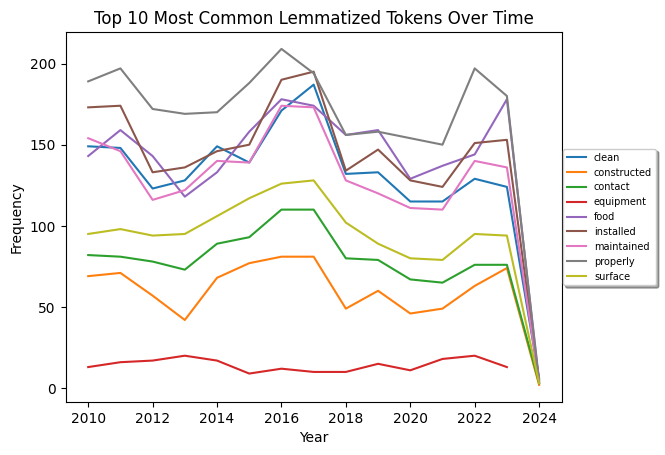

In [309]:
import matplotlib.pyplot as plt
year_descriptions_10_summary.pivot(index="Year", columns="tokens", values="Count").plot()
ax = plt.subplot(111)
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5),
          fancybox=True, shadow=True, fontsize="7")
plt.title('Top 10 Most Common Lemmatized Tokens Over Time')
plt.ylabel('Frequency')
plt.show()

In [304]:
# def new_dispersion_plot(text, words, ignore_case=False, title="Lexical Dispersion Plot"):
#     """
#     Generate a lexical dispersion plot.

#     :param text: The source text
#     :type text: list(str) or iter(str)
#     :param words: The target words
#     :type words: list of str
#     :param ignore_case: flag to set if case should be ignored when searching text
#     :type ignore_case: bool
#     :return: a matplotlib Axes object that may still be modified before plotting
#     :rtype: Axes
#     """

#     try:
#         import matplotlib.pyplot as plt
#     except ImportError as e:
#         raise ImportError(
#             "The plot function requires matplotlib to be installed. "
#             "See https://matplotlib.org/"
#         ) from e

#     word2y = {
#         word.casefold() if ignore_case else word: y
#         for y, word in enumerate(reversed(words))
#     }
#     xs, ys = [], []
#     for x, token in enumerate(text):
#         token = token.casefold() if ignore_case else token
#         y = word2y.get(token)
#         if y is not None:
#             xs.append(x)
#             ys.append(y)

#     _, ax = plt.subplots()
#     ax.plot(xs, ys, "|")
#     #ax.set_yticks(list(range(len(words))), words, color="C0") # Broken
#     ax.set_yticks(list(range(len(words))), list(word2y.keys()), color="C0")
#     ax.set_ylim(-1, len(words))
#     ax.set_title(title)
#     ax.set_xlabel("Word Offset")
#     return ax

In [305]:
# import matplotlib.pyplot as plt

# dispersion = new_dispersion_plot(vds_tokens_clean_lemmatized, vds_10, title="Lexical Dispersion of Top 10 Lemmatized Violation Descriptions")

# plt.show()